# NBA Point Spread Regressor Experiments

## Imports

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.season_game as sg
import utils_nba_point_spead_reg as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from boruta import BorutaPy
import dataframe_image as dfi

## Setup

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

sns.set(style="whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 60 seconds


### Utils functions

In [23]:
def filter_from(items, cond):
    return list(filter(cond, items)) 

In [24]:
def del_result_by(exp_name):
    global results_total
    results_total = filter_from(results_total, lambda i: i[0] != exp_name)
    utils_exp.exp_results = filter_from(utils_exp.exp_results, lambda i: i['exp_name'] != exp_name)

In [25]:
def get_result_by(exp_name):
    global results_total
    return next((x for x in results_total if x[0] == exp_name), None)

In [19]:
#del_result_by('reg_1_season')
#utils_exp.exp_results
#utils.deserialize_object(f'result_totals', [])

In [26]:
def del_exp_result(exp_name):
    for idx, res in enumerate(list(utils_exp.exp_results)):
        if res['exp_name'] == exp_name:
            del utils_exp.exp_results[idx]

In [27]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [28]:
def plot_results(experiment_name, results, figsize=(10,6)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    #     a = sns.pointplot(data=results_df,
    #               kind="point", x="season_test", y="rmse", hue="model"
    #               )
    a = sns.lineplot(
        data=results_df,
        x="season_test", y="mae", hue="model", style="model",
        markers=True, dashes=False
    )
    a.set_title(
        f"{experiment_name}-mae")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [29]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [30]:
reg_metrics = ['mae', 'mse', 'rmse']

def print_prettier_exp_results(exp_name, metric='mae', filter_val=None):
    second_metric = 'rmse' if metric == 'mae' else 'mae'
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std', f'{second_metric}_mean', f'{second_metric}_std']]
    cond = ba_df.exp_name == exp_name
    if filter_val is not None:
        cond = (ba_df.exp_name == exp_name) & (ba_df.model == filter_val)
    return ba_df[cond].sort_values(by=[f"{metric}_mean"], ascending=True)

## Load Dataset

In [31]:
season_games = sg.load_season_games_dataset()

## Dataset


In [26]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [32]:
df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

In [33]:
print(df.shape)
df = df.dropna()
print(df.isnull().sum().sum())
print(df.shape)
df.drop(df[df.G_PLAYED < 20].index, inplace = True)
print(df.shape)
utils.serialize_object('df', df)

(9599, 405)
0
(9461, 405)


In [37]:
df_styled = df[model_config.X_REG_COLS_BEST_BORUTA].head(5)
to_image = df_styled.T
dfi.export(to_image, 'reg_fs_first_5_games.png')

df_styled = df[model_config.X_REG_COLS_BEST_BORUTA].tail(5)
to_image = df_styled.T
dfi.export(to_image, 'reg_fs_last_5_games.png')

## Experiments

### Setup

In [34]:
exp_prefix = "reg_"
## exp_group_name = "reg_experiments"
exp_suffix = "fs"
exp_group_name = "reg_experiments_boruta"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = []
TARGET = "HOME_POINT_SPREAD"
exp_X_columns = model_config.X_REG_COLS_BEST_BORUTA
exp_y_columns = model_config.Y_REG_COL

models = utils_exp.get_reg_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

### Feature selection

In [124]:
def dict_to_list(d):
    dictlist = []
    for key, value in d.items():
        temp = [key,value]
        dictlist.append(temp)
    return pd.DataFrame(data=dictlist)

In [125]:
# instantiate random forest
from collections import defaultdict

## RandomForest
model = models[4][1]

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
folds_selected_features = defaultdict(int)
boruta_selector = BorutaPy(model, n_estimators = 200, random_state = 0)
list_selected_features = []
for train_idx, test_idx in folds[:]:
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    y_true = y_test
    # fit boruta
    boruta_selector.fit(np.array(X_train), np.array(y_train))
    boruta_ranking = boruta_selector.ranking_
    selected_features = np.array(exp_X_columns)[boruta_ranking <= 2]
    list_selected_features.append(selected_features)
    for f in selected_features:
        folds_selected_features[f]+=1
#dict_to_list(folds_selected_features)
# # store results
# boruta_ranking = boruta_selector.ranking_
# selected_features = np.array(feature_names)[boruta_ranking <= 2]

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

In [126]:
f_df = dict_to_list(folds_selected_features)

In [141]:
f_df.sort_values(by=[1, 0], ascending=False)
#f_df[f_df[1] > 2]
final_selected_features = list(f_df[0].unique())
sorted(final_selected_features)
final_selected_features

,0,1
4,HOME_PLUS_MINUS_MEAN,7
3,HOME_PLUS_MINUS_L10,7
2,HOME_FT_PCT,7
1,HOME_FG3_PCT,7
7,PLUS_MINUS_MEAN_HOME,3
15,HOME_PLUS_MINUS_ML10,3
11,W_L_CUM_HOME,2
17,PTS_ML10_HOME,2
8,PTS_MEAN_HOME,2
6,HOME_FG_PCT_MEAN,2


['BLK_L10_AWAY',
 'BLK_MEAN_AWAY',
 'BLK_MEAN_HOME',
 'FG_PCT_MEAN_HOME',
 'FG_PCT_ML10_HOME',
 'FT_PCT_L10_AWAY',
 'FT_PCT_ML10_HOME',
 'HOME_FG3_PCT',
 'HOME_FG_PCT_MEAN',
 'HOME_FT_PCT',
 'HOME_PF_ML10',
 'HOME_PLUS_MINUS_L10',
 'HOME_PLUS_MINUS_MEAN',
 'HOME_PLUS_MINUS_ML10',
 'PF_ML10_AWAY',
 'PLUS_MINUS_MEAN_HOME',
 'PTS_MEAN_HOME',
 'PTS_ML10_HOME',
 'STL_L10_HOME',
 'STL_MEAN_AWAY',
 'STL_MEAN_HOME',
 'W_L_CUM_HOME']

['FT_PCT_L10_AWAY',
 'HOME_FG3_PCT',
 'HOME_FT_PCT',
 'HOME_PLUS_MINUS_L10',
 'HOME_PLUS_MINUS_MEAN',
 'PF_ML10_AWAY',
 'HOME_FG_PCT_MEAN',
 'PLUS_MINUS_MEAN_HOME',
 'PTS_MEAN_HOME',
 'STL_MEAN_AWAY',
 'STL_MEAN_HOME',
 'W_L_CUM_HOME',
 'FG_PCT_MEAN_HOME',
 'FT_PCT_ML10_HOME',
 'HOME_PF_ML10',
 'HOME_PLUS_MINUS_ML10',
 'BLK_MEAN_HOME',
 'PTS_ML10_HOME',
 'BLK_L10_AWAY',
 'BLK_MEAN_AWAY',
 'STL_L10_HOME',
 'FG_PCT_ML10_HOME']

In [130]:
f_df.sort_values(by=[1, 0], ascending=False)
#best_boruta = list_selected_features[3]
#sorted(best_boruta)
#best_boruta

,0,1
4,HOME_PLUS_MINUS_MEAN,7
3,HOME_PLUS_MINUS_L10,7
2,HOME_FT_PCT,7
1,HOME_FG3_PCT,7
7,PLUS_MINUS_MEAN_HOME,3
15,HOME_PLUS_MINUS_ML10,3
11,W_L_CUM_HOME,2
17,PTS_ML10_HOME,2
8,PTS_MEAN_HOME,2
6,HOME_FG_PCT_MEAN,2


#### Test best features

In [132]:
#[x for x in exp_X_columns if x not in final_selected_features]
X_boruta = df_sscv[final_selected_features]
y_boruta = df_sscv[TARGET]

experiment_name = f"{exp_prefix}2_seasons_boruta"
del_result_by(experiment_name)
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)


params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name, metric='mae')

Running experiment reg_2_seasons_boruta
Done


KeyError: "['precision_std', 'precision_mean'] not in index"

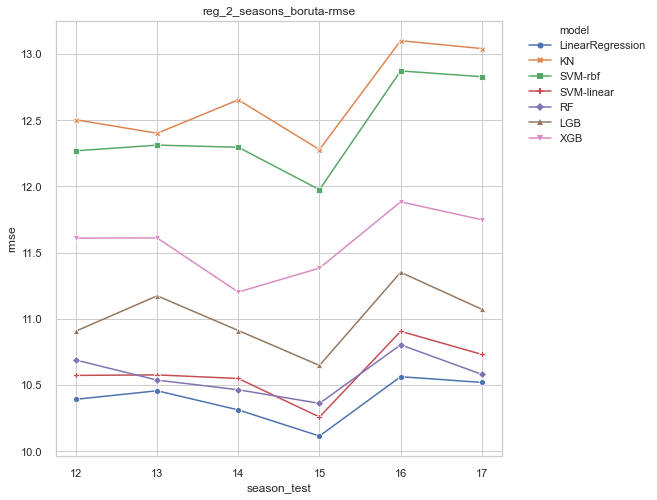

In [133]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,8))

#### Test specific best feature set

In [134]:
for idx, features in enumerate(list_selected_features):
    X_boruta = df_sscv[features]
    y_boruta = df_sscv[TARGET]

    experiment_name = f"{exp_prefix}2_seasons_boruta_specific_{idx}"
    del_result_by(experiment_name)
    folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)

    params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
    names, results = utils_exp.run_experiment(*params)
    results_total.append((experiment_name, results))
    #print_prettier_exp_results(experiment_name, metric='mae')

Running experiment reg_2_seasons_boruta_specific_0
Done
Running experiment reg_2_seasons_boruta_specific_1
Done
Running experiment reg_2_seasons_boruta_specific_2
Done
Running experiment reg_2_seasons_boruta_specific_3
Done
Running experiment reg_2_seasons_boruta_specific_4
Done
Running experiment reg_2_seasons_boruta_specific_5
Done
Running experiment reg_2_seasons_boruta_specific_6
Done


#### Test custom best feature set

In [ ]:
X_COLS_BEST_BORUTA = ['FG_PCT_MEAN_AWAY',
                      'FG_PCT_MEAN_HOME',
                      'FT_PCT_ML10_AWAY',
                      'HOME_FG3_PCT',
                      'HOME_FG_PCT_L10',
                      'HOME_FG_PCT_MEAN',
                      'HOME_FT_PCT',
                      'HOME_FT_PCT_ML10',
                      'HOME_PLUS_MINUS_L10',
                      'HOME_PLUS_MINUS_MEAN',
                      'HOME_PLUS_MINUS_ML10',
                      'PLUS_MINUS_L10_AWAY',
                      'PLUS_MINUS_L10_HOME',
                      'PLUS_MINUS_MEAN_AWAY',
                      'PLUS_MINUS_MEAN_HOME',
                      'W_L_CUM_AWAY',
                      'W_L_CUM_HOME']
X_boruta = df_sscv[X_COLS_BEST_BORUTA]
y_boruta = df_sscv[TARGET]

experiment_name = f"{exp_prefix}2_seasons_boruta_custom"
del_result_by(experiment_name)
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)

params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))
print_prettier_exp_results(experiment_name, metric='mae')

### Experiment using 1 season

In [31]:
#### START EXPERIMENTS

experiment_name = f"{exp_prefix}1_season_{exp_suffix}"

In [32]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_1_season_fs
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
2,reg_1_season_fs,SVM,9.709728,0.248954,12.359978,0.311276
0,reg_1_season_fs,LR,9.712155,0.249430,12.348681,0.324234
1,reg_1_season_fs,KNN,9.926655,0.233279,12.626371,0.294890
3,reg_1_season_fs,RF,10.234509,0.229760,12.977831,0.304698
4,reg_1_season_fs,LGB,11.071290,0.322990,13.982674,0.381113
5,reg_1_season_fs,XGB,11.399061,0.313937,14.434766,0.379982


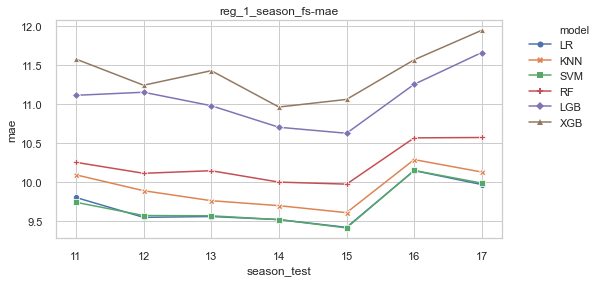

In [33]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [34]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10,1213,11,972
1,11,972,12,1209
2,12,1209,13,1213
3,13,1213,14,1213
4,14,1213,15,1213
5,15,1213,16,1214
6,16,1214,17,1214


### Experiment using StandardScaler

In [35]:
experiment_name = f"{exp_prefix}scaled_data_{exp_suffix}"

In [36]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, exp_X_columns)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_scaled_data_fs
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
8,reg_scaled_data_fs,SVM,9.704364,0.251180,12.352054,0.315157
6,reg_scaled_data_fs,LR,9.712155,0.249430,12.348681,0.324234
7,reg_scaled_data_fs,KNN,9.939329,0.268842,12.606903,0.323512
9,reg_scaled_data_fs,RF,10.235777,0.231564,12.976893,0.304432
10,reg_scaled_data_fs,LGB,11.109947,0.292585,14.058958,0.367407
11,reg_scaled_data_fs,XGB,11.401324,0.306916,14.435082,0.368159


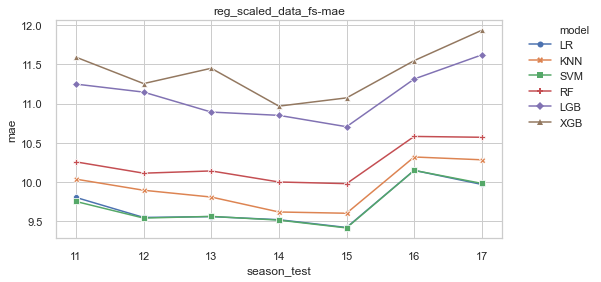

In [37]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))


In [38]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10,1213,11,972
1,11,972,12,1209
2,12,1209,13,1213
3,13,1213,14,1213
4,14,1213,15,1213
5,15,1213,16,1214
6,16,1214,17,1214


### Experiment using MinMaxScaler

In [39]:
experiment_name = f"{exp_prefix}minmax_data_{exp_suffix}"

In [40]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, exp_X_columns)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_minmax_data_fs
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
14,reg_minmax_data_fs,SVM,9.709945,0.244932,12.346036,0.315257
12,reg_minmax_data_fs,LR,9.712348,0.249821,12.348263,0.325652
13,reg_minmax_data_fs,KNN,9.945070,0.262371,12.599919,0.318253
15,reg_minmax_data_fs,RF,10.234655,0.232230,12.978482,0.306211
16,reg_minmax_data_fs,LGB,11.073908,0.307505,13.971070,0.381269
17,reg_minmax_data_fs,XGB,11.402322,0.308777,14.436679,0.371748


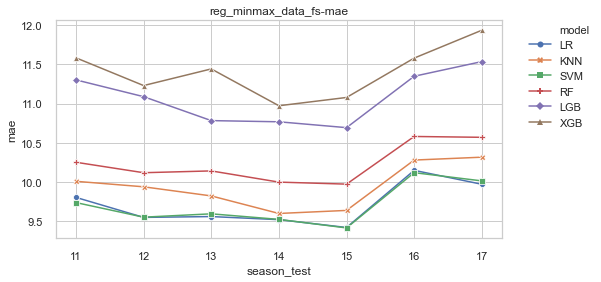

In [41]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [42]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10,1213,11,972
1,11,972,12,1209
2,12,1209,13,1213
3,13,1213,14,1213
4,14,1213,15,1213
5,15,1213,16,1214
6,16,1214,17,1214


### Experiment: train: 2s; test: 1s

In [43]:
experiment_name = f"{exp_prefix}2_seasons_{exp_suffix}"

In [44]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)



Running experiment reg_2_seasons_fs
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
18,reg_2_seasons_fs,LR,9.691466,0.261354,12.328091,0.345472
20,reg_2_seasons_fs,SVM,9.692615,0.275733,12.347609,0.344295
19,reg_2_seasons_fs,KNN,9.933945,0.226334,12.639381,0.305907
21,reg_2_seasons_fs,RF,10.093767,0.219851,12.848433,0.271779
22,reg_2_seasons_fs,LGB,10.506244,0.160355,13.342199,0.265075
23,reg_2_seasons_fs,XGB,11.122878,0.193054,14.109457,0.233455


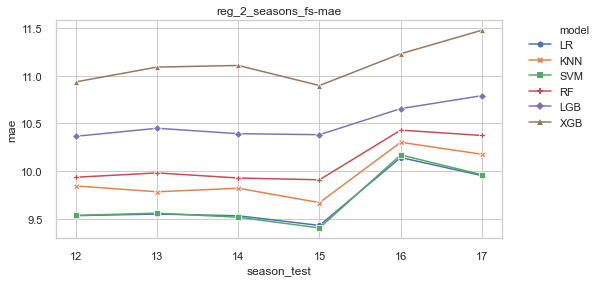

In [45]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [46]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10-11,2185,12,1209
1,11-12,2181,13,1213
2,12-13,2422,14,1213
3,13-14,2426,15,1213
4,14-15,2426,16,1214
5,15-16,2427,17,1214


### Experiment: train: 3s; test: 1s

In [47]:
experiment_name = f"{exp_prefix}3_seasons_{exp_suffix}"

In [48]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_3_seasons_fs
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
24,reg_3_seasons_fs,LR,9.714275,0.280367,12.348300,0.375227
26,reg_3_seasons_fs,SVM,9.716377,0.288250,12.369593,0.368767
25,reg_3_seasons_fs,KNN,9.935432,0.250126,12.628795,0.350073
27,reg_3_seasons_fs,RF,10.063509,0.252410,12.798406,0.317382
28,reg_3_seasons_fs,LGB,10.376436,0.217624,13.148672,0.300189
29,reg_3_seasons_fs,XGB,11.027268,0.247233,14.008420,0.306289


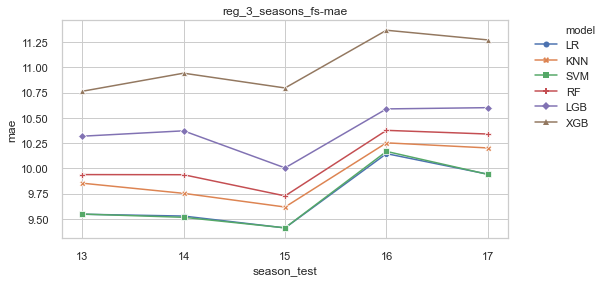

In [49]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [50]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10-11-12,3394,13,1213
1,11-12-13,3394,14,1213
2,12-13-14,3635,15,1213
3,13-14-15,3639,16,1214
4,14-15-16,3640,17,1214


### Experiment remove last 2q ; train: 2q ; test: 2q

In [97]:
experiment_name = f"{exp_prefix}2q_2q_rl2q_{exp_suffix}"

In [52]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=2, remove_quarters=[0.75, 1.0])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_2q_2q_rl2q_fs
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
32,reg_2q_2q_rl2q_fs,SVM,9.834998,0.306828,12.458822,0.369356
30,reg_2q_2q_rl2q_fs,LR,9.844534,0.295781,12.456457,0.380054
31,reg_2q_2q_rl2q_fs,KNN,10.038167,0.237869,12.732503,0.337394
33,reg_2q_2q_rl2q_fs,RF,10.391161,0.239404,13.130910,0.361468
34,reg_2q_2q_rl2q_fs,LGB,11.368738,0.346700,14.326554,0.449148
35,reg_2q_2q_rl2q_fs,XGB,11.629524,0.371700,14.705296,0.434283


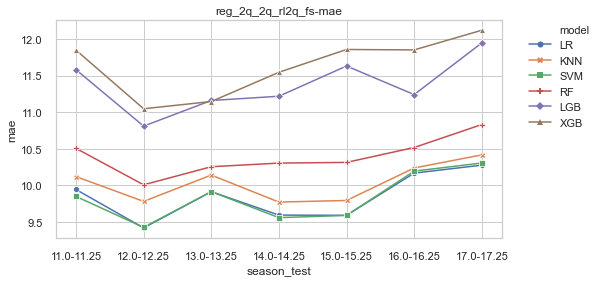

In [98]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [54]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.0-10.25,606,11.0-11.25,486
1,11.0-11.25,486,12.0-12.25,604
2,12.0-12.25,604,13.0-13.25,606
3,13.0-13.25,606,14.0-14.25,606
4,14.0-14.25,606,15.0-15.25,606
5,15.0-15.25,606,16.0-16.25,607
6,16.0-16.25,607,17.0-17.25,607


### Experiment remove first 2q ;train: 2q ; test: 2q

In [55]:
experiment_name = f"{exp_prefix}2q_2q_rf2q_{exp_suffix}"

In [56]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=2, remove_quarters=[0.25, 0.5])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_2q_2q_rf2q_fs
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
38,reg_2q_2q_rf2q_fs,SVM,9.588992,0.306236,12.265363,0.357013
36,reg_2q_2q_rf2q_fs,LR,9.601347,0.328686,12.273745,0.377621
37,reg_2q_2q_rf2q_fs,KNN,9.747616,0.349169,12.461176,0.357133
39,reg_2q_2q_rf2q_fs,RF,10.193296,0.327371,12.982444,0.355746
40,reg_2q_2q_rf2q_fs,LGB,11.209980,0.407940,14.144414,0.396051
41,reg_2q_2q_rf2q_fs,XGB,11.447531,0.312437,14.582748,0.387987


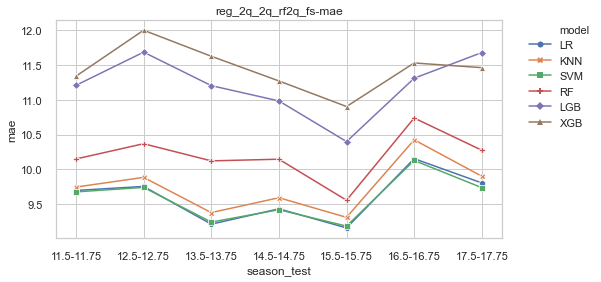

In [57]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [58]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.5-10.75,607,11.5-11.75,486
1,11.5-11.75,486,12.5-12.75,605
2,12.5-12.75,605,13.5-13.75,607
3,13.5-13.75,607,14.5-14.75,607
4,14.5-14.75,607,15.5-15.75,607
5,15.5-15.75,607,16.5-16.75,607
6,16.5-16.75,607,17.5-17.75,607


### Experiment train: remove last 1q ; 3q ; test: 1q ; step: 3q

In [59]:
experiment_name = f"{exp_prefix}3q_1q_r1q_s3q_{exp_suffix}"

In [60]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1, remove_quarters=[1.0], skip_size=3)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_3q_1q_r1q_s3q_fs
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
42,reg_3q_1q_r1q_s3q_fs,LR,9.769106,0.189336,12.322299,0.292009
44,reg_3q_1q_r1q_s3q_fs,SVM,9.777840,0.207052,12.349039,0.292939
43,reg_3q_1q_r1q_s3q_fs,KNN,9.898074,0.260151,12.577080,0.289394
45,reg_3q_1q_r1q_s3q_fs,RF,10.288982,0.280907,13.035259,0.212275
46,reg_3q_1q_r1q_s3q_fs,LGB,11.247516,0.302367,14.268608,0.292871
47,reg_3q_1q_r1q_s3q_fs,XGB,11.523614,0.312879,14.536481,0.340161


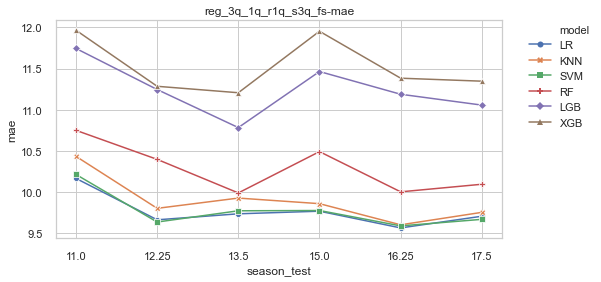

In [61]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [62]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.0-10.25-10.5,909,11.0,243
1,11.25-11.5-12.0,788,12.25,302
2,12.5-13.0-13.25,908,13.5,303
3,14.0-14.25-14.5,909,15.0,303
4,15.25-15.5-16.0,909,16.25,304
5,16.5-17.0-17.25,910,17.5,303


### Experiment train: 3q ; test: 1q ; step: 3q

In [63]:
experiment_name = f"{exp_prefix}3q_1q_3s_{exp_suffix}"

In [64]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1, skip_size=3)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_3q_1q_3s_fs
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
48,reg_3q_1q_3s_fs,LR,9.619819,0.318413,12.350993,0.367947
50,reg_3q_1q_3s_fs,SVM,9.712091,0.331073,12.474682,0.395869
49,reg_3q_1q_3s_fs,KNN,9.778818,0.374172,12.481131,0.458928
51,reg_3q_1q_3s_fs,RF,10.102893,0.407709,13.012230,0.537123
52,reg_3q_1q_3s_fs,LGB,10.748052,0.361167,13.814832,0.489293
53,reg_3q_1q_3s_fs,XGB,11.457070,0.684908,14.736256,0.962377


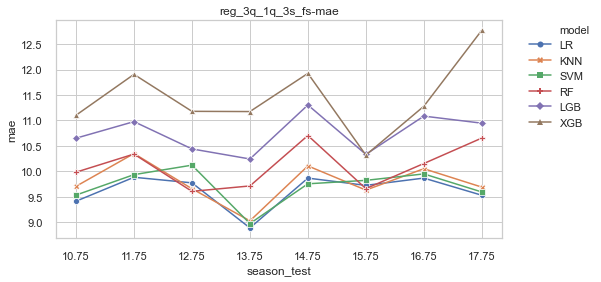

In [65]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [66]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.0-10.25-10.5,909,10.75,304
1,11.0-11.25-11.5,729,11.75,243
2,12.0-12.25-12.5,906,12.75,303
3,13.0-13.25-13.5,909,13.75,304
4,14.0-14.25-14.5,909,14.75,304
5,15.0-15.25-15.5,909,15.75,304
6,16.0-16.25-16.5,910,16.75,304
7,17.0-17.25-17.5,910,17.75,304


### Experiment train: 4q ; test: 2q

In [67]:
# experiment_name = f"{exp_prefix}4q_2q_{exp_suffix}"

In [68]:
# del_result_by(experiment_name)

# folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
# params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
# names, results = utils_exp.run_experiment(*params)
# results_total.append((experiment_name, results))

# print_prettier_exp_results(experiment_name)

In [69]:
# #### Visualize experiments results
# name, res = get_result_by(experiment_name)
# plot_results(name, res, figsize=(30,10))

In [70]:
# utils.folds_to_df(folds, train_seasons, test_seasons)

### Experiment remove first 2q ; train: 4q ; test: 2q

In [99]:
experiment_name = f"{exp_prefix}4q_2q_rf2q_{exp_suffix}"

In [72]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2, remove_quarters=[0.25, 0.50])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

#### END EXPERIMENTS

Running experiment reg_4q_2q_rf2q_fs
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
54,reg_4q_2q_rf2q_fs,LR,9.540633,0.322641,12.209445,0.379313
56,reg_4q_2q_rf2q_fs,SVM,9.544767,0.316822,12.217240,0.374861
55,reg_4q_2q_rf2q_fs,KNN,9.695948,0.372435,12.430341,0.406636
57,reg_4q_2q_rf2q_fs,RF,9.947114,0.323051,12.723088,0.377813
58,reg_4q_2q_rf2q_fs,LGB,10.692503,0.386596,13.616124,0.391644
59,reg_4q_2q_rf2q_fs,XGB,11.045932,0.264549,13.994016,0.324293


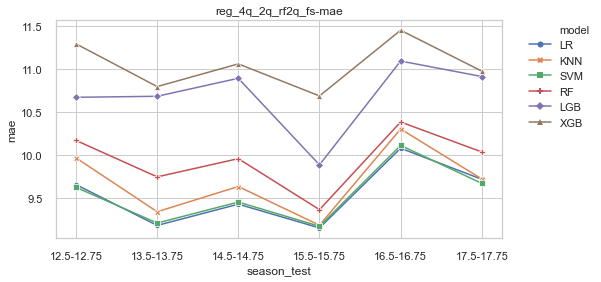

In [100]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [74]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.5-10.75-11.5-11.75,1093,12.5-12.75,605
1,11.5-11.75-12.5-12.75,1091,13.5-13.75,607
2,12.5-12.75-13.5-13.75,1212,14.5-14.75,607
3,13.5-13.75-14.5-14.75,1214,15.5-15.75,607
4,14.5-14.75-15.5-15.75,1214,16.5-16.75,607
5,15.5-15.75-16.5-16.75,1214,17.5-17.75,607


### Experiments comparison

In [75]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)
utils.serialize_object(f'result_totals_{exp_group_name}', results_total)

In [76]:
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = utils.deserialize_object(exp_group_name, [])
exp_df = get_results_df()

In [77]:
ba_df = exp_df[~exp_df.exp_name.isin(['reg_minmax_data', 'reg_scaled_data'])][['exp_name', 'model',
       'mae_mean', 'mae_std', 'rmse_mean', 'rmse_std']]

In [78]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [101]:
ba_df.sort_values(
    by=["mae_mean"]
    , ascending=True)[:10].reset_index().drop(labels=["index"], axis=1)

,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
0,reg_4q_2q_rf2q_fs,LR,9.540633,0.322641,12.209445,0.379313
1,reg_4q_2q_rf2q_fs,SVM,9.544767,0.316822,12.217240,0.374861
2,reg_2q_2q_rf2q_fs,SVM,9.588992,0.306236,12.265363,0.357013
3,reg_2q_2q_rf2q_fs,LR,9.601347,0.328686,12.273745,0.377621
4,reg_3q_1q_3s_fs,LR,9.619819,0.318413,12.350993,0.367947
5,reg_2_seasons_fs,LR,9.691466,0.261354,12.328091,0.345472
6,reg_2_seasons_fs,SVM,9.692615,0.275733,12.347609,0.344295
7,reg_4q_2q_rf2q_fs,KNN,9.695948,0.372435,12.430341,0.406636
8,reg_scaled_data_fs,SVM,9.704364,0.251180,12.352054,0.315157
9,reg_1_season_fs,SVM,9.709728,0.248954,12.359978,0.311276


### Plot experiment results

#### MAE

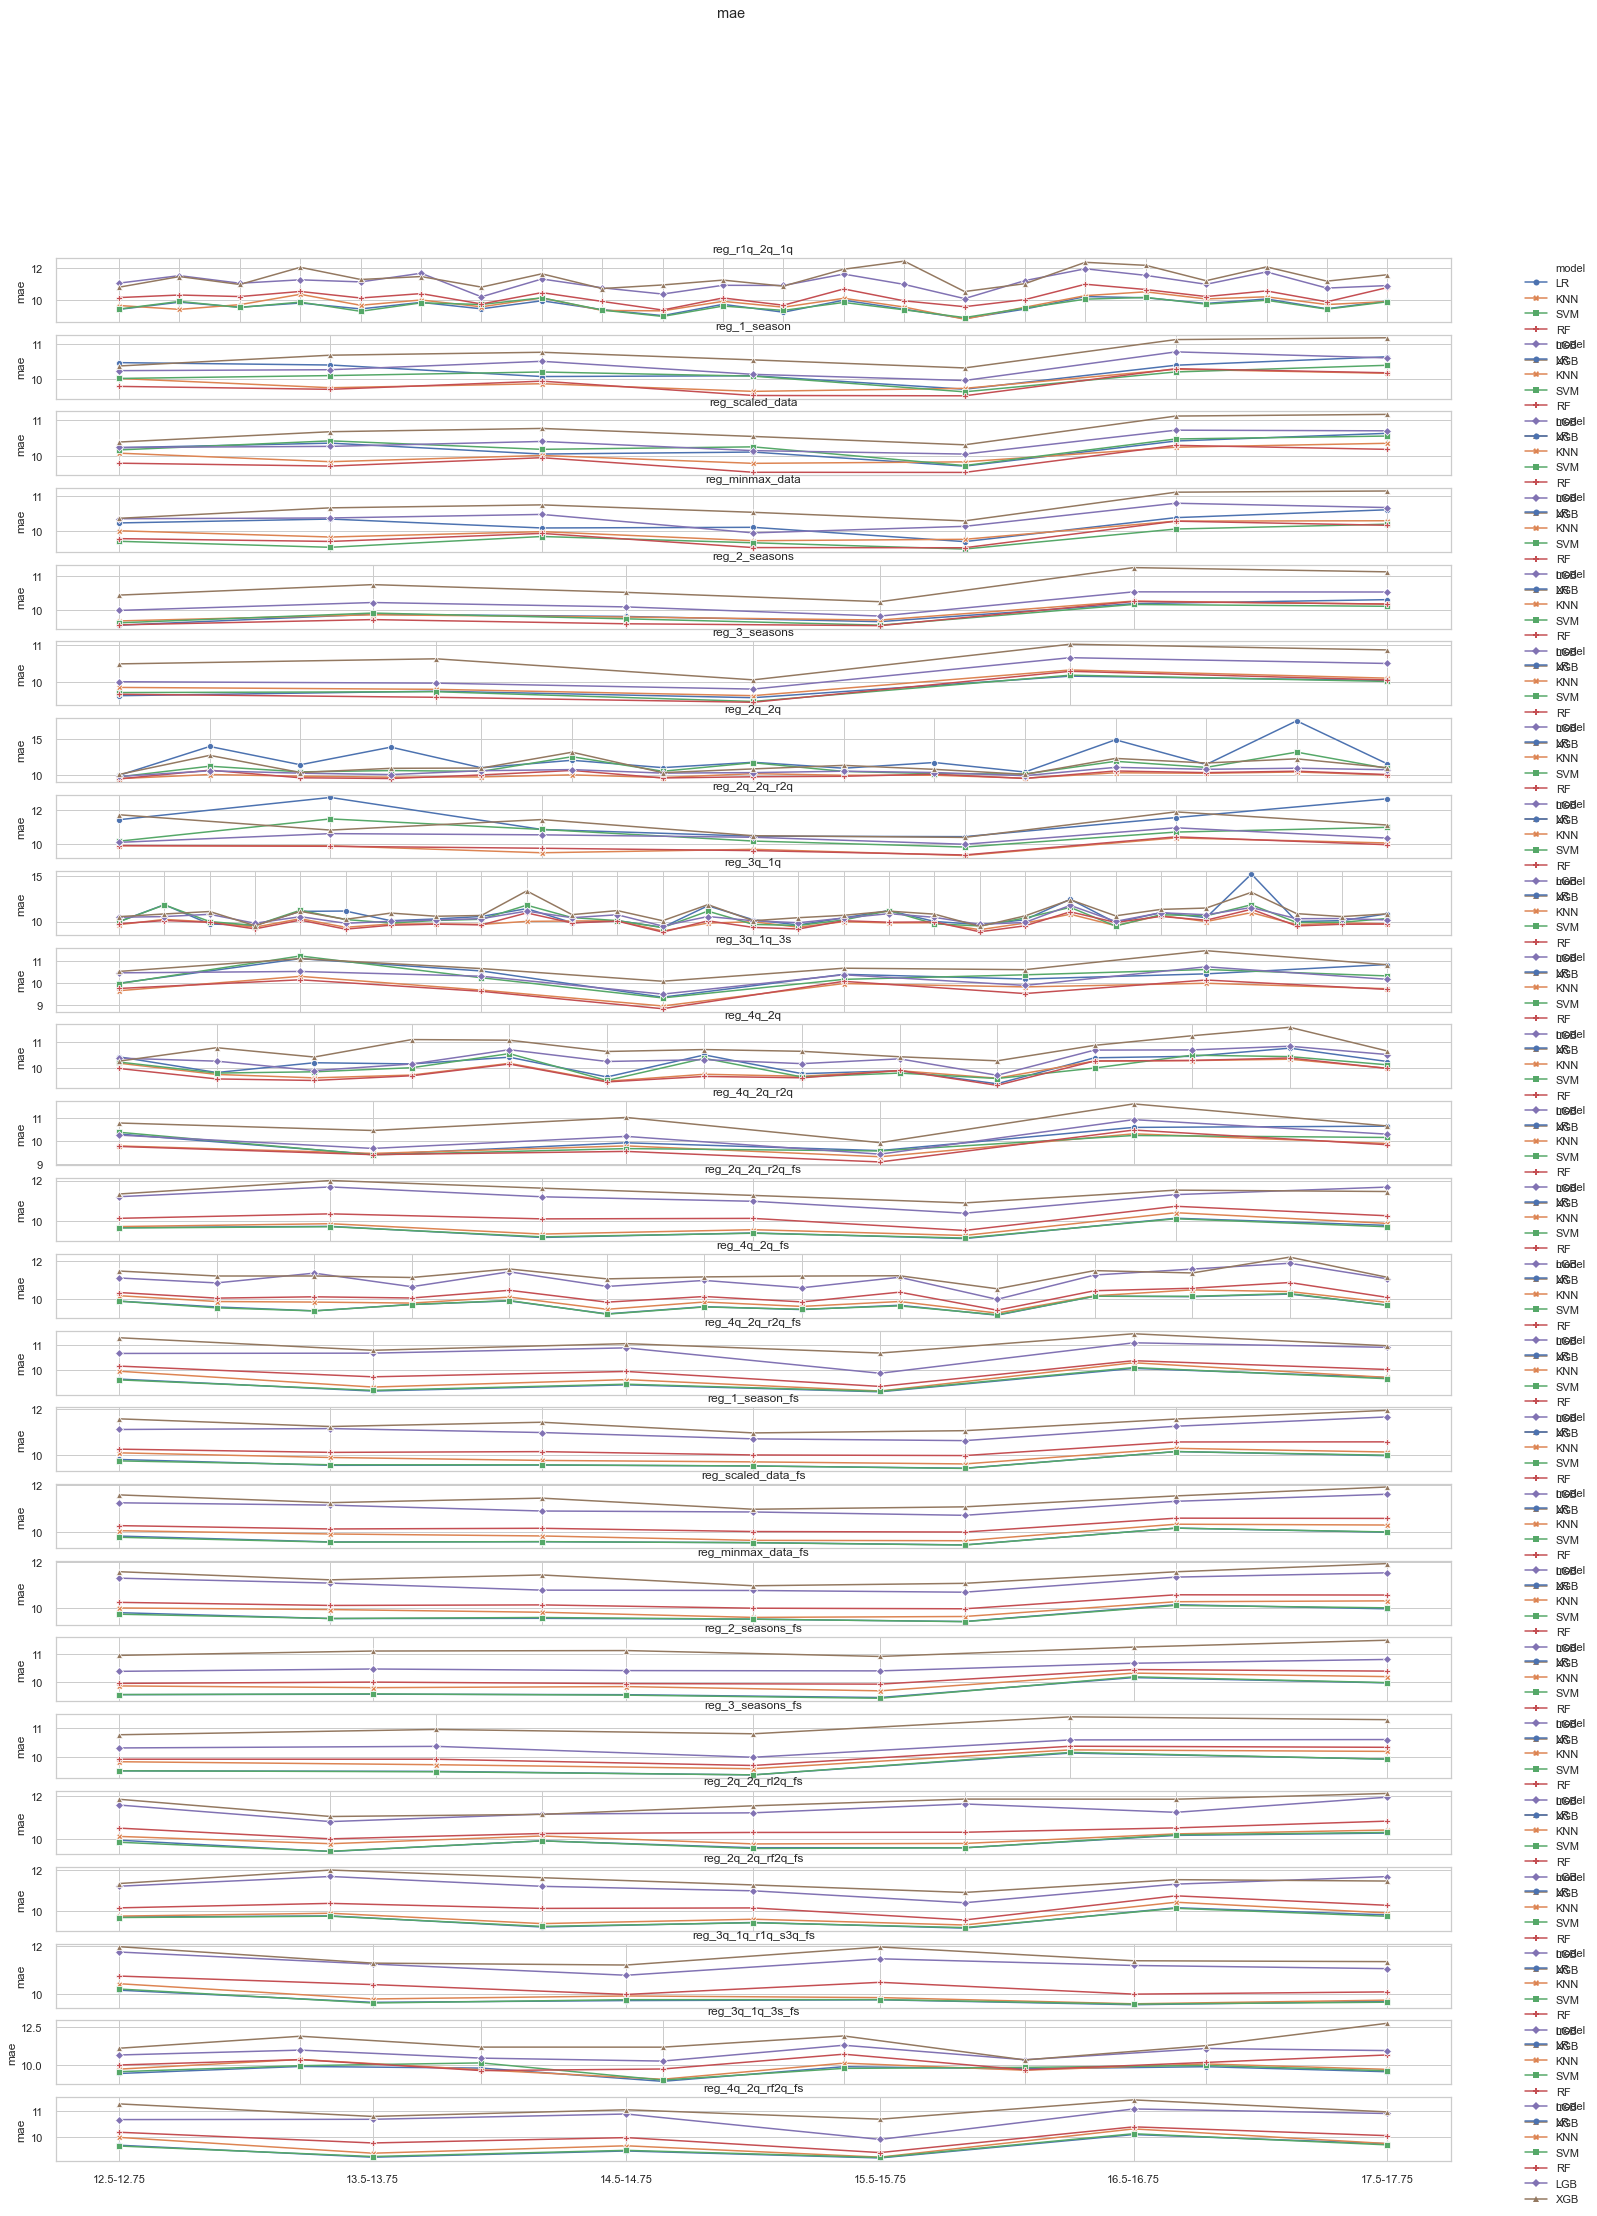

In [80]:
utils.plot_to_compare_experiments(
    results_total,
    metric="mae",
    figsize=(25, 35),
    use_pointplot=True
)

#### MSE

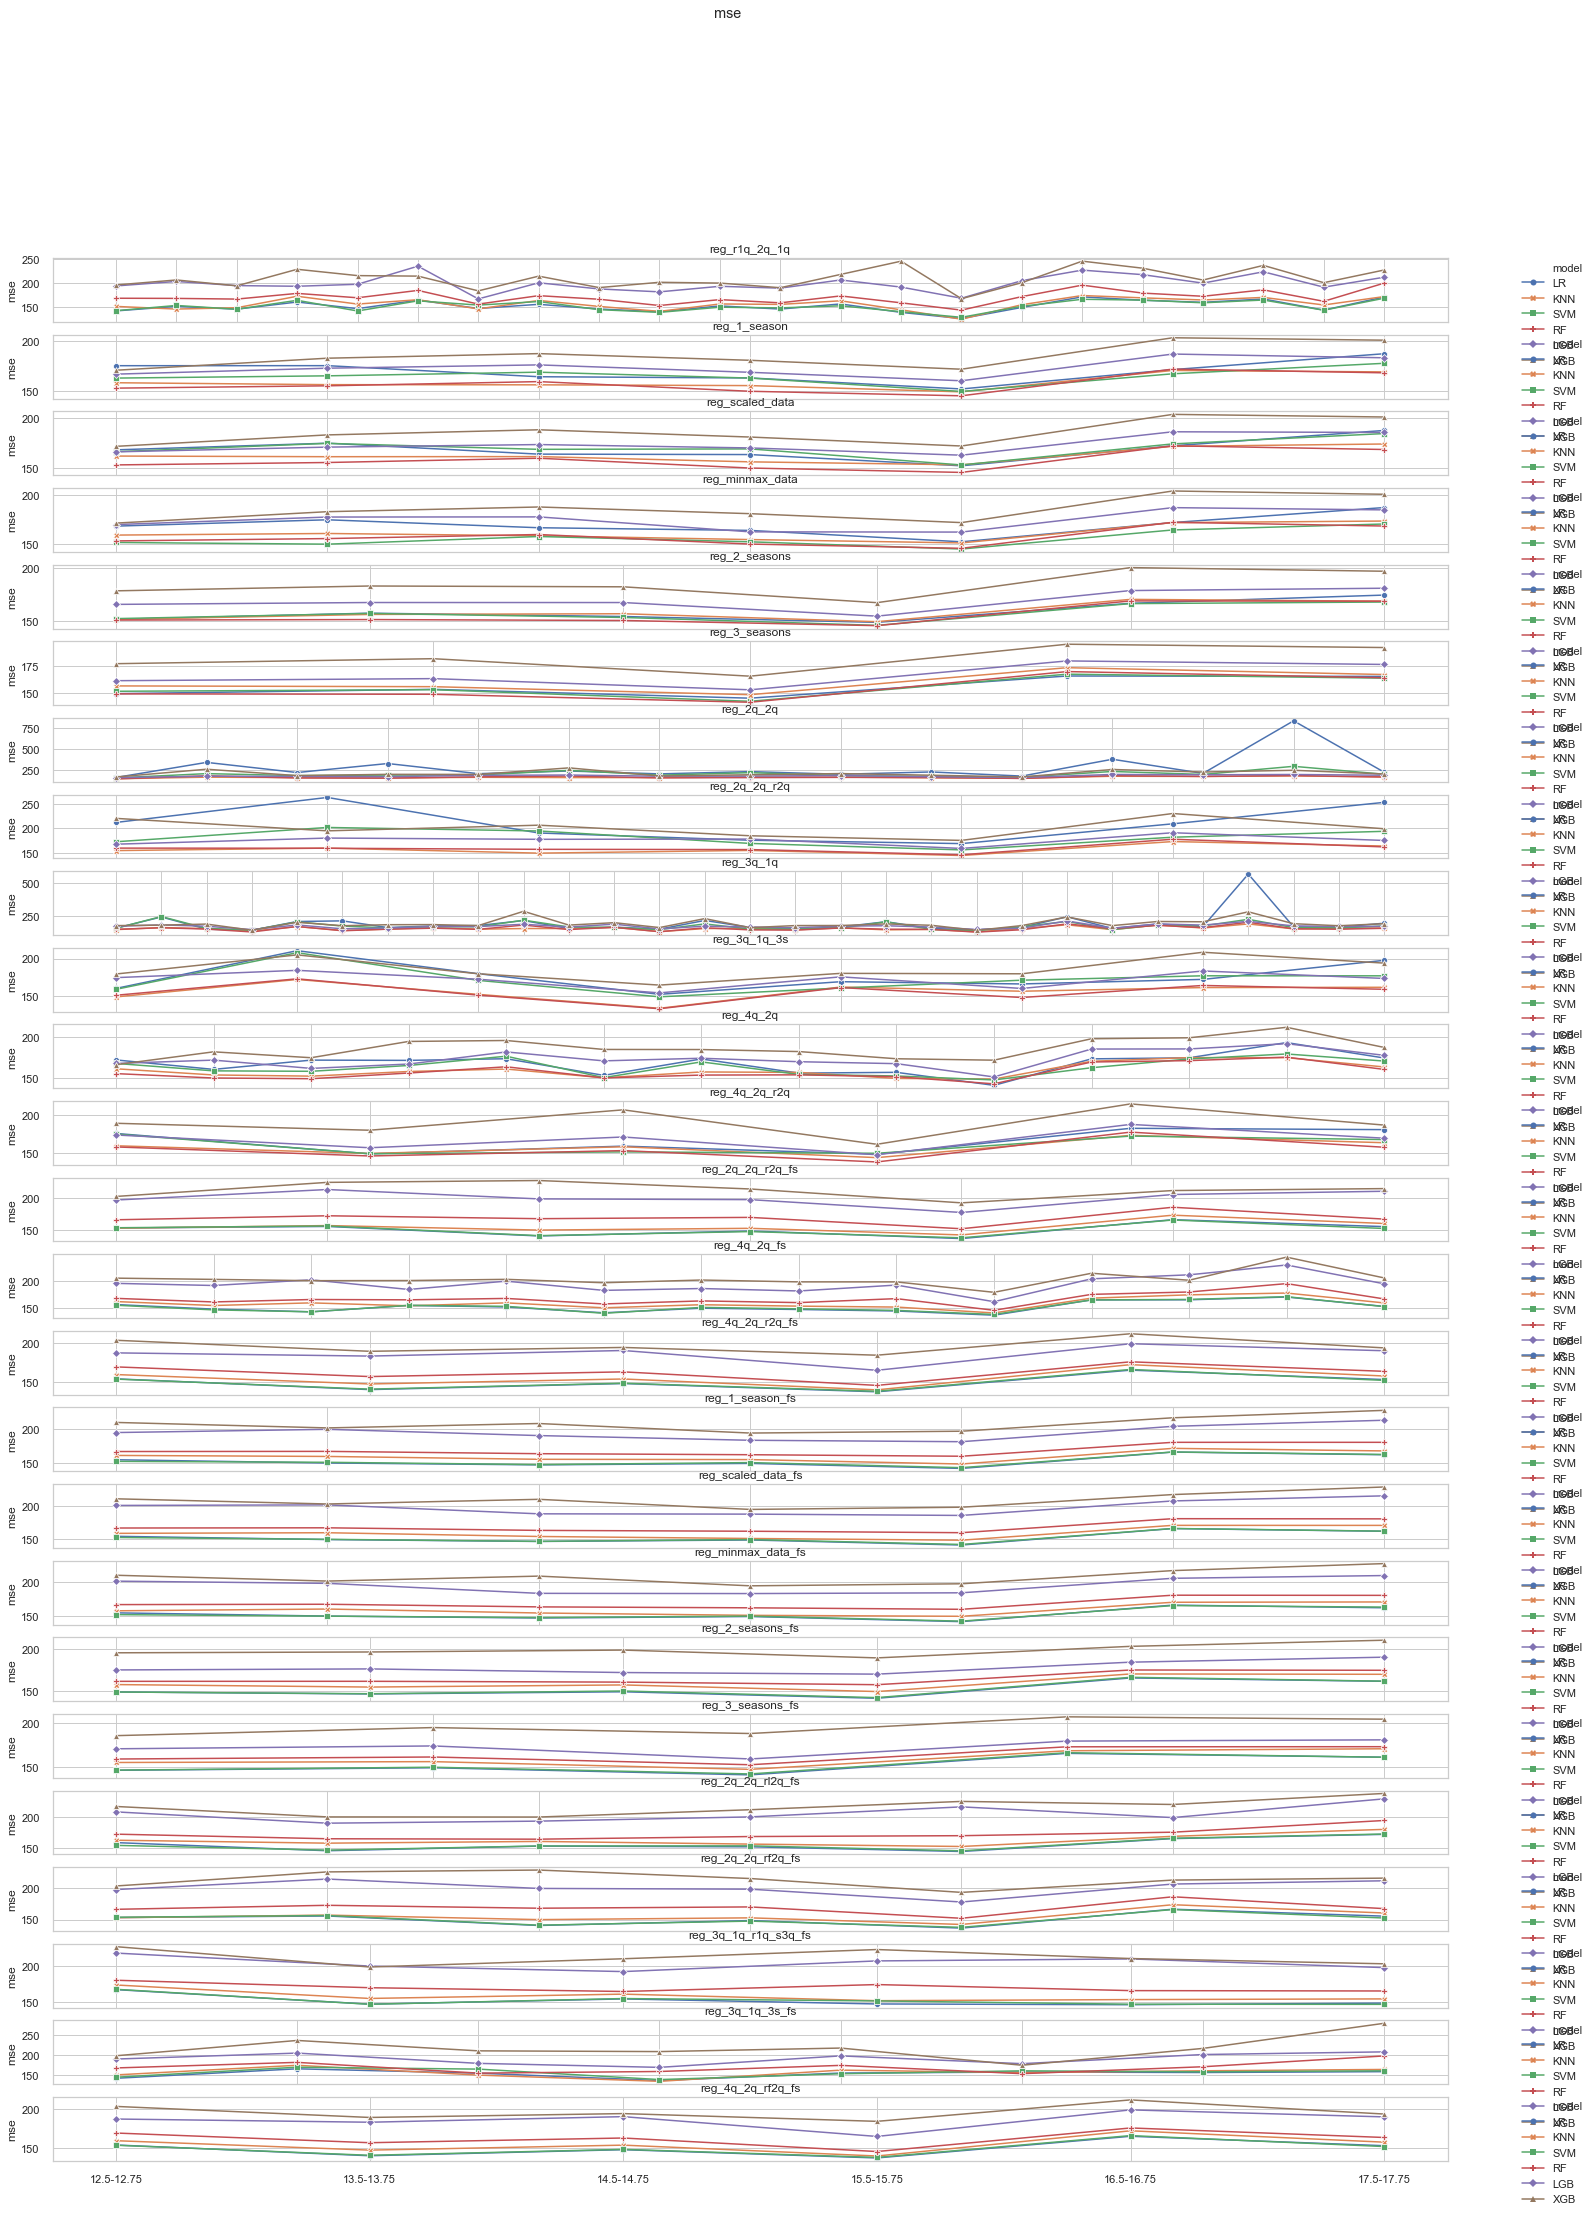

In [81]:
utils.plot_to_compare_experiments(
    results_total,
    metric="mse",
    figsize=(25, 35),
    use_pointplot=True
)

#### RMSE

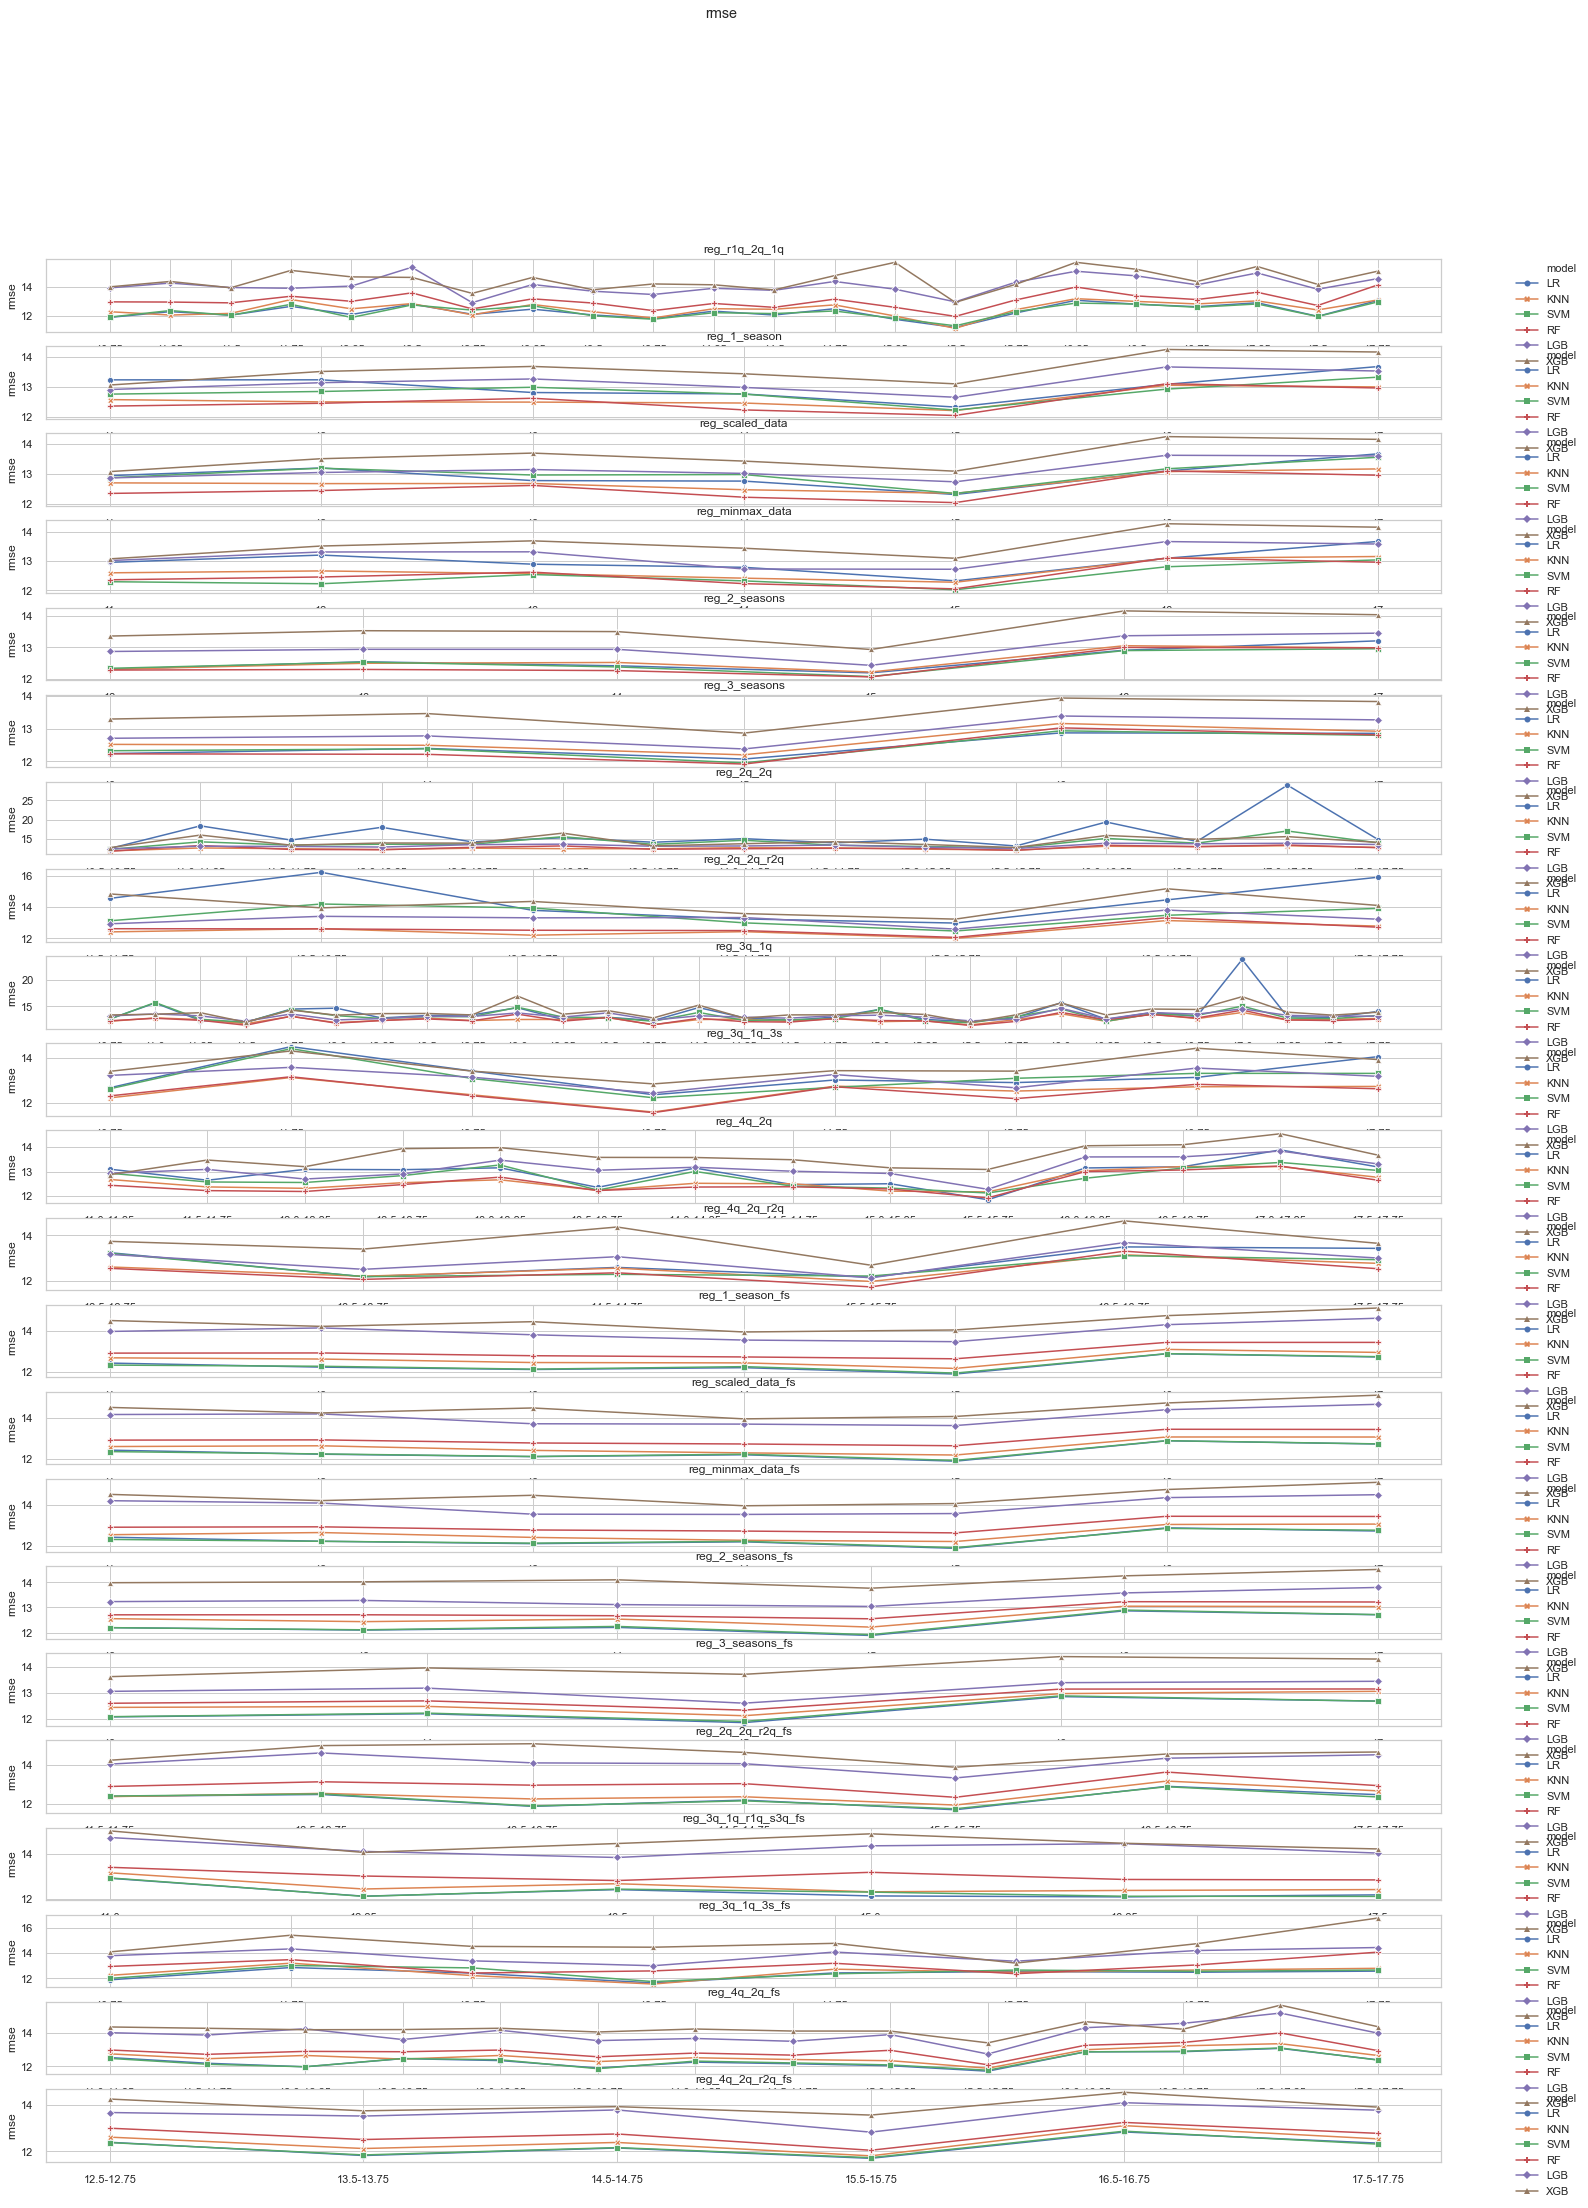

In [90]:
utils.plot_to_compare_experiments(
    results_total,
    metric="rmse",
    figsize=(25, 35),
    use_pointplot=True
)

### hyperparameter optimization

#### Imports

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import mean_absolute_error
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hpsklearn import HyperoptEstimator
import hpsklearn
from hyperopt.pyll import scope, as_apply
from hyperopt import SparkTrials, STATUS_OK

#### Dataset

In [16]:
op_df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]

##### Seasons

In [17]:
op_df.SEASON.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

##### Clean Data

In [18]:
print(op_df.shape)
op_df = op_df.dropna()
print(op_df.isnull().sum().sum())
print(op_df.isna().sum().sum())
print(op_df.shape)

(9599, 261)
0
0
(9461, 261)


#### setup

In [19]:
exp_prefix = "reg_"
#exp_group_name = "clf_experiments"
exp_group_name = "reg_op"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])

op_models = utils_exp.get_reg_models()

op_sscv = utils.SeasonSeriesSplit(op_df)
op_df_sscv = op_sscv.get_df()
op_X = op_df_sscv[exp_X_columns]
op_y = op_df_sscv[TARGET]



#### Utils

In [20]:
def walk_forward_val_mean_score(input_model):
    metric_results = []
    for train_idx, test_idx in folds:
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        y_true = y_test

        pipeline = Pipeline(steps=[
                ('model', input_model)])

        model = pipeline
        fit_info = pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        metric_results.append(mean_absolute_error(y_true, y_pred))

    return np.mean(metric_results)



#### Optimization

In [21]:
folds, train_seasons, test_seasons = op_sscv.split(train_size=2, test_size=1)

In [22]:
# name = 'reg'
# models =[
#     #hpsklearn.svc(name + '.SVM'),
#     #hpsklearn.random_forest(name + '.RF'),
#     #hpsklearn.xgboost_regression(name + '.XGB'),
#     #hpsklearn.lightgbm_regression(name + '.LGB')
#     hpsklearn.svc_linear(name + 'SVM')
# ]

# estim = HyperoptEstimator(regressor=hp.choice('%s' % name, models),
#                           preprocessing=None,
#                           algo=tpe.suggest,
#                           max_evals=500,
#                           trial_timeout=120)


# train_idx, test_idx = folds[-2]
# X_train, X_test = X.loc[train_idx], X.loc[test_idx]
# y_train, y_test = y.loc[train_idx], y.loc[test_idx]
# y_true = y_test

# estim.fit(X_train, y_train)
# print(estim.score(X_test, y_test))
# print(estim.best_model())

#### LightGBM

In [24]:
# 'objective': 'binary',
#     'metric': 'binary_logloss',
# #     'sub_feature': 0.5,
#     'min_data': 50,
#     'n_estimators': 500,
#     'metric': 'auc'

# objective='binary',
# metric='auc',

space = {
    'max_depth': hp.uniform('max_depth', 1, 11),
    'num_leaves': hp.uniform('num_leaves', 2, 121),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.5)) - 0.0001,
    'n_estimators': hp.quniform('n_estimators', 100, 6000, 200),
    'gamma': hp.loguniform('gamma', np.log(0.0001), np.log(5)) - 0.0001,
    'min_child_weight': hp.loguniform('min_child_weight', np.log(1), np.log(100)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.0001), np.log(1)) - 0.0001,
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1), np.log(4)),
    #boosting_type: hp.choice(name, ['gbdt', 'dart', 'goss'])
    'boosting_type': hp.choice('boosting_type', ['gbdt'])
}

default_hiperparameters = {
    'objective': 'binary',
    #'random_state': 0
}

def objective(space):
    print(space)
    hiperparameters = {**default_hiperparameters, **space}
    hiperparameters['max_depth'] = int(hiperparameters['max_depth'])
    hiperparameters['num_leaves'] = int(hiperparameters['num_leaves'])
    hiperparameters['n_estimators'] = int(hiperparameters['n_estimators'])
    hiperparameters['min_child_weight'] = int(hiperparameters['min_child_weight'])
    model = lgb.LGBMRegressor(
        **hiperparameters
    )

    accuracy = walk_forward_val_mean_score(model)

    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()
spark_trials = SparkTrials()
best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=200,
        trials=spark_trials,
        rstate=np.random.RandomState(seed=0),
        return_argmin=False
    )
best

Because the requested parallelism was None or a non-positive value, parallelism will be set to (8), which is Spark's default parallelism (8), or the current total of Spark task slots (8), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.


  1%|          | 2/200 [02:11<3:36:51, 65.72s/trial, best loss: -10.997595591186654]


Total Trials: 10: 2 succeeded, 8 failed, 0 cancelled.


KeyboardInterrupt: 

#### Experiment

In [91]:
lgbparams = {'boosting_type': 'gbdt',
 'colsample_bylevel': 0.6708923954804659,
 'colsample_bytree': 0.6000110807769761,
 'gamma': 0.3506689603388255,
 'learning_rate': 4.812206492908419e-08,
 'max_depth': 3.7205211307390265,
 'min_child_weight': 17.191236445639678,
 'n_estimators': 1200.0,
 'num_leaves': 95.60966938610218,
 'reg_alpha': 0.030016928545628624,
 'reg_lambda': 3.283314946517291,
 'subsample': 0.6085661260416309}

op_model = [
#     ("RF", RandomForestClassifier(
#                                       criterion='gini',
#                                       n_estimators=200,
#                                       max_depth=18,
#                                       max_leaf_nodes = 24,
#                                       min_samples_leaf = 2,
#                                       min_samples_split = 3,
#                                       n_jobs=-1,
#                                       random_state=0))
    ("LGB", lgb.LGBMRegressor(
        **lgbparams
#                 boosting_type='goss', colsample_bytree=0.758794422460012,
#               learning_rate=0.0009853276762182032, max_delta_step=0,
#               max_depth=6, min_child_weight=47, n_estimators=4600, n_jobs=1,
#               num_leaves=113, objective='regression',
#               reg_alpha=0.34215270718724283, reg_lambda=3.676702330857159,
#               scale_pos_weight=1, seed=0, subsample=0.9582168858299254)
    ))
]

In [92]:
experiment_name = f"{exp_prefix}2_seasons_op"
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, op_model, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name[:-3], metric='mae', filter_val=op_model[0][0])
print_prettier_exp_results(experiment_name)


# 0	reg_2_seasons	LR	8.192009	0.136491	10.392967	0.148882
# 2	reg_2_seasons	SVM	8.313091	0.182380	10.599064	0.196440
# 3	reg_2_seasons	RF	8.345848	0.111711	10.585308	0.150436
# 4	reg_2_seasons	LGB	8.702064	0.201812	11.010843	0.223081
# 5	reg_2_seasons	XGB	9.194161	0.189745	11.583278	0.253444
# 1	reg_2_seasons	KNN	9.952810	0.230096	12.663717	0.3101

name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

Running experiment reg_2_seasons_op


LightGBMError: Parameter num_leaves should be of type int, got "95.60966938610218"

### Final validation

#### Dataset

In [221]:
fv_df = season_games[(season_games.SEASON >= 2016)]

##### Seasons

In [222]:
fv_df.SEASON.unique()

array([2016, 2017, 2018, 2019])

##### clean data

In [223]:
print(fv_df.shape)
fv_df = fv_df.dropna()
print(fv_df.isnull().sum().sum())
print(fv_df.isna().sum().sum())
print(fv_df.shape)

(4749, 261)
0
0
(4685, 261)


#### setup

In [224]:
exp_prefix = "reg_"
exp_group_name = "reg_final_validation"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])

fv_models = utils_exp.get_reg_models()

fv_sscv = utils.SeasonSeriesSplit(fv_df)
fv_df_sscv = fv_sscv.get_df()
fv_X = fv_df_sscv[exp_X_columns]
fv_y = fv_df_sscv[TARGET]

#### experiment

In [225]:
experiment_name = f"{exp_prefix}2_seasons_fv"

In [226]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = fv_sscv.split(train_size=2, test_size=1)
params = (experiment_name, fv_models, folds, train_seasons, test_seasons, fv_X, fv_y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_2_seasons_fv
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
0,reg_2_seasons_fv,LR,8.126956,0.155930,10.451102,0.314840
2,reg_2_seasons_fv,SVM,8.335560,0.139586,10.753539,0.295023
3,reg_2_seasons_fv,RF,8.399878,0.096542,10.745538,0.285764
4,reg_2_seasons_fv,LGB,8.811712,0.092612,11.226358,0.256028
5,reg_2_seasons_fv,XGB,9.241210,0.283491,11.692705,0.454053
1,reg_2_seasons_fv,KNN,10.491738,0.021062,13.378785,0.096284


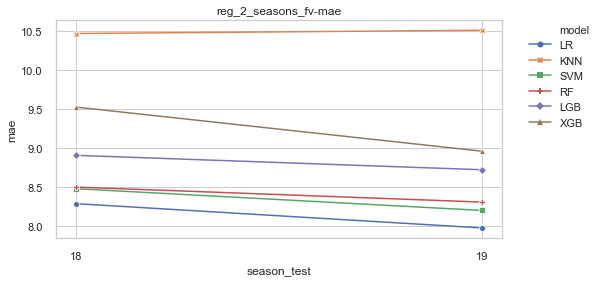

In [227]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))